# `transformnd` tutorial

`transformnd` is a python library which provides implementations of coordinate transformations, base classes to ensure a consistent API across implementations, and utilities for combining and working with those coordinate transformations.

First, define a basic shape, and make a function for plotting it:

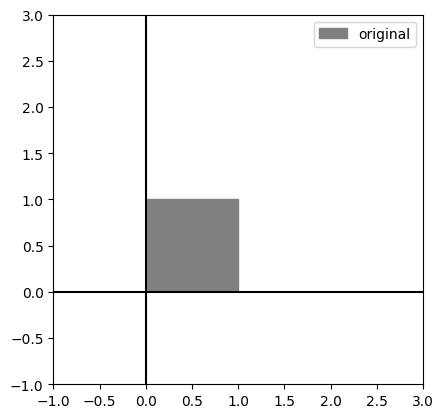

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon

rng = np.random.default_rng(1991)

# Array of N coordinates in D dimensions has shape NxD
square = np.array(
    [
        [0, 0],
        [0, 1],
        [1, 1],
        [1, 0],
    ]
)


def plot_shape(**kwargs):
    """Draw a labelled polygon from kwargs like name=coords."""
    ax = plt.gca()
    min_ = -1
    max_ = 3
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.hlines(0, min_, max_, colors="k")
    ax.vlines(0, min_, max_, colors="k")
    ax.set_aspect("equal")
    sq = Polygon(square, closed=False, color="grey", label="original")
    ax.add_patch(sq)

    cmap = plt.get_cmap("tab10")

    for idx, (name, coords) in enumerate(kwargs.items()):
        poly = Polygon(coords, closed=False, label=name, color=cmap(idx))
        ax.add_patch(poly)
    plt.legend()


plot_shape()

Now we'll add some basic transformations.

Transformations are subclasses of the `Transform` abstract base class.
Once the transformation is instantiated, it can be used just like a function, transforming a numpy array of coordinates into a new numpy array.


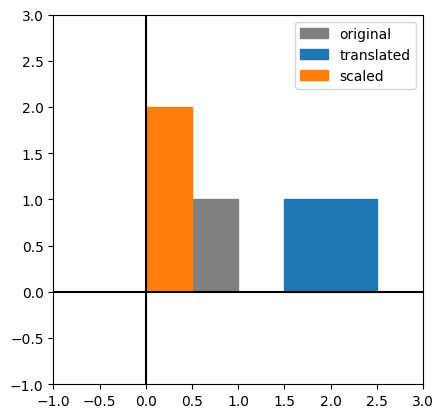

In [2]:
from transformnd.transforms.simple import Translate, Scale

translate = Translate([1.5, 0])
scale = Scale([0.5, 2])

plot_shape(
    translated=translate.apply(square),
    scaled=scale.apply(square),
)

## `TransformSequence`

Transforms can be chained together into a single transformation, with the `TransformSequence` class.

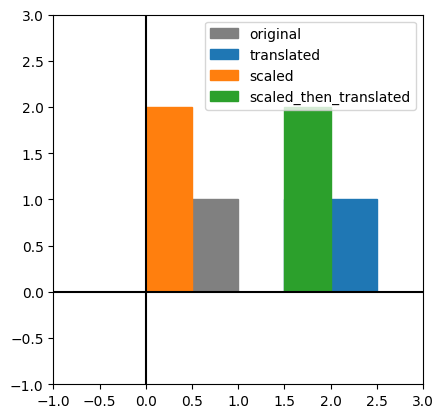

In [3]:
from transformnd import TransformSequence

scale_then_translate = TransformSequence([scale, translate])

plot_shape(
    translated=translate.apply(square),
    scaled=scale.apply(square),
    scaled_then_translated=scale_then_translate.apply(square),
)

## Composing and inverting transformations

`TransformSequences` can also be constructed with the `|` operator.

Certain transformations can be inverted with the `~` operator.

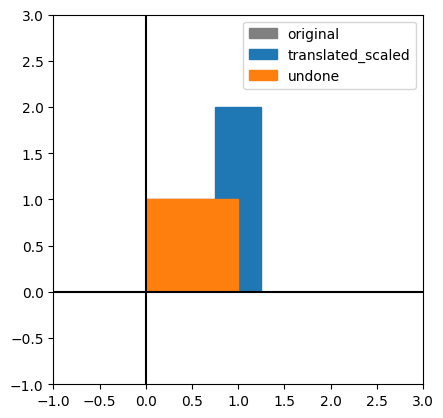

In [4]:
translate_scale = translate | scale
# Note that translate -> scale gives different results to scale -> translate above
# because the scaling is done around (0, 0)

undo_translate_scale = ~translate_scale
# Note that if you want to immediately call an inverted transform,
# you need to use brackets to ensure the inversion happens first:
#
#     (~my_transform)(my_coordinates)

plot_shape(
    translated_scaled=translate_scale.apply(square),
    undone=undo_translate_scale.apply(translate_scale.apply(square)),
)

## Affine transformations

A common class of coordinate transformations are affine transformations.
These require a transformation matrix which then multiplies the coordinate array.
`transformnd` provides convenience methods for constructing this transformation matrix out of common operations: translations, scales, reflections, rotations, and shears.

Because this all uses matrix multiplication under the hood, `AffineTransform` instances can be composed using the matrix multiplication operator `@` rather than needing to apply the transforms one at a time in a `TransformSequence`.

Affine transformations are invertible.

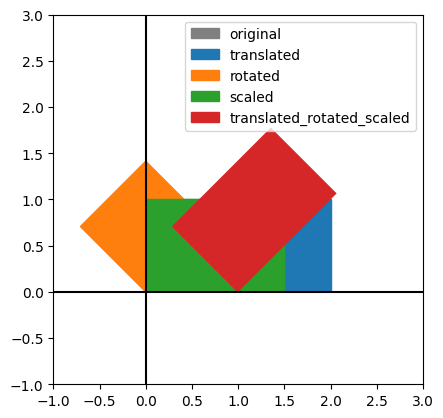

In [5]:
from transformnd.transforms.affine import Affine

tran = Affine.translation([1, 0])
rot = Affine.rotation2(45)  # Only 2D, 3D have convenient constructors
sca = Affine.scaling([1.5, 1])
tran_rot_sca = tran @ rot @ sca

plot_shape(
    translated=tran.apply(square),
    rotated=rot.apply(square),
    scaled=sca.apply(square),
    translated_rotated_scaled=tran_rot_sca.apply(square),
)

## Spaces and bridging transforms

A common task in coordinate transformation is to convert coordinates in one space (e.g. a pixel index of an image) into some other space (e.g. a location in "world" space, using the image's resolution and offset).

All `Transform`s can take the keyword arguments `spaces` on instantiation, which is a tuple of two hashable values (e.g. a string or number).
If not `None`, these values act as a reference to the spaces the transform goes from and to respectively.
This makes it easier to reason about what space the coordinates start and end in.

`TransformSequence` instances check that consecutive transforms in the sequence refer to consistent spaces (if spaces are defined).
They will also use a transform with a defined target space to infer the source space of the next transform, if undefined.

Once you have a set of transforms between different defined spaces, you can do bridging transforms: calculating how to get from one space to another by applying some subset of those transforms in sequence.
This uses the `TransformGraph` class (requires `networkx`).

The `TransformGraph` will automatically unpack any transforms inside sequences (if they have spaces defined), and infer inverse transforms where possible.

In [6]:
from transformnd.graph import TransformGraph

g = TransformGraph()
ab = Scale(2, spaces=("a", "b"))
bc = Translate([0.5, 1], spaces=("b", "c"))
bd = Translate([1, 0.5], spaces=("b", "d"))

g.add_transforms([ab, bc, bd])

print("Transform sequence from a to c:", g.get_sequence("a", "c"))

print("Transform sequence from d to a:", g.get_sequence("d", "a"))

Transform sequence from a to c: TransformSequence[a->b->c]
Transform sequence from d to a: TransformSequence[d->b->a]


## Making your own `Transform`

There are many different types of transformation, which have been implemented in many different ways in many different libraries.
`transformnd` makes it easy to bring lots of different implementations under one interface, which can then make use of the same composition tools.

`Transform` is an abstract base class with a number of utility methods already implemented.
At a minimum, you just need to subclass it and implement the `.__call__` method.
If your transformation is only defined for certain dimensionalities, that can also be specified: use the `._validate_coords` method to check that passed-in coordinates are of the right shape. [1]

You can also optionally implement `.__invert__`, if the transformation is invertible.

[1]: N.B. `TransformSequence` and `TransformGraph` both ensure that their component transforms have compatible dimensionalities.

In [7]:
from transformnd import Transform


class IsotropicScale2d(Transform):
    ndim = {2}  # a set of valid dimensionalities

    def __init__(self, factor: float, *, spaces=(None, None)):
        # ensure the spaces are handled properly
        super().__init__(spaces=spaces)
        self.factor = factor

    def apply(self, coords: np.ndarray) -> np.ndarray:
        # ensure the coordinates are of the right shape
        coords = self._validate_coords(coords)
        return coords * self.factor

    def __invert__(self):
        return IsotropicScale2d(
            1 / self.factor,
            spaces=self.spaces[::-1],
        )

## Adapters

Lots of objects have coordinates, but many other features too.
`transformnd` makes it easy to transform arbitrary python objects like this using adapters.
Basically, you define a subclass of `transformnd.adapters.BaseAdapter` and implement `.__call__`, which takes a transform and an object.
This method will get coordinates from the object, and construct a new one from the transformed coordinates and the old object.

For cases where an object has transformable attributes, there is the `AttrAdapter`, which takes key-value pairs of the name of the transformable attribute, and an adapter which knows how to apply a transform to that attribute.
Cases where the attribute is just a coordinate array can use the `NullAdapter`.

If you're going to use the same adapter-transform combination a lot, you can use `Adapter.partial` to create a callable representing that combination.

When writing your own `Adapter`, consider giving the `__call__` method an `in_place` keyword argument if you have the option of modifying the existing object rather than creating a new one.
`AttrAdapter`s which compose over other adapters will save themselves some copying by using this argument intelligently.

In [8]:
from dataclasses import dataclass
from transformnd.adapters import AttrAdapter, ReshapeAdapter

# 2D coordinates arranged in an array
odd_shaped_coordinates = rng.random((5, 3, 2, 4))
reshape = ReshapeAdapter(2)  # the axis containing each coordinate
odd_shaped_transformed = reshape.apply(translate, odd_shaped_coordinates)
assert odd_shaped_coordinates.shape == odd_shaped_transformed.shape

# Custom class:


@dataclass
class Town:
    houses: np.ndarray
    shops: np.ndarray


my_town = Town(
    houses=rng.random((5, 2)),
    shops=rng.random((3, 2)),
)

# None says "this variable doesn't need adapting for transformation"
# i.e. it's already a numpy array of the correct shape
town_adapter = AttrAdapter(houses=None, shops=None)
translated_town = town_adapter.apply(translate, my_town)

town_translator = town_adapter.partial(translate)
translated_town_2 = town_translator(translated_town)

`transformnd` includes adapters for instances of `meshio.Mesh`, `pandas.DataFrame` (where certain columns make up a coordinate array), and geometries from `shapely`.
These are only available if you have the requisite dependencies installed. 

In [9]:
from transformnd.adapters.pandas import DataFrameAdapter
import pandas as pd

df = pd.DataFrame(
    np.random.random((3, 5)),
    columns=["x", "y", "z", "radius", "weight"],
)

print("original")
print(df)


print("\nscaled")
xyz_adapter = DataFrameAdapter(["x", "y", "z"])
scale3d = Scale([1, 10, 100])
print(xyz_adapter.apply(scale3d, df))

original
          x         y         z    radius    weight
0  0.139821  0.837466  0.696267  0.960034  0.643765
1  0.880310  0.207630  0.420473  0.267383  0.440152
2  0.126083  0.185112  0.463040  0.955462  0.948093

scaled
          x         y          z    radius    weight
0  0.139821  8.374658  69.626716  0.960034  0.643765
1  0.880310  2.076296  42.047303  0.267383  0.440152
2  0.126083  1.851117  46.303989  0.955462  0.948093
